In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv("/kaggle/input/individual-test-spai-sorting-hat/train.csv")
train.head()

,user_id,house
0,4b2569be-cd32-40aa-9cc4-9e13e55903de,house1
1,cdd098ee-4295-4839-b1a3-4d44840feacd,house3
2,226c662f-b1b3-40bc-9bfc-4f49a80b9041,house6
3,7889a31f-7351-4b4d-b872-e04e5e35b9dd,house2
4,0492584f-5dda-4ad6-ab2f-79c8d43a8753,house1


In [6]:
att = pd.read_csv("/kaggle/input/individual-test-spai-sorting-hat/attendance.csv")
att.head()

,user_id,datetime
0,5931fa6a-af6b-43b8-babb-28349854d406,2024-04-19 17:30:08.827555
1,5f1a2ecf-943d-446b-b94d-d7d1ad64213d,2024-04-19 17:30:11.405020
2,6e009a96-2b8b-4048-8b0c-20a7924a4b4f,2024-04-19 17:30:14.433098
3,cdd098ee-4295-4839-b1a3-4d44840feacd,2024-04-19 17:30:17.214453
4,f922a5d4-3651-46f7-aa98-307c045dd4b5,2024-04-19 17:30:21.556805


In [ ]:
att['user_id'].value_counts()

## Merging Files

In [11]:
train['user_id'].dtype , att['user_id'].dtype

(dtype('O'), dtype('O'))

In [14]:
result = train.merge(att, on='user_id', how='outer')

In [24]:
result['user_id'].value_counts()

user_id
0492584f-5dda-4ad6-ab2f-79c8d43a8753    68
5b4b687b-64db-4ee8-9fd6-42931ca7576c    68
6f16696b-22a0-4f3c-b2ad-f6b9e0256775    68
e3aca4f2-7e1e-4499-bf8f-55355b2849da    68
6915145d-8404-412b-9481-1768b7863e3e    68
                                        ..
71d0528a-188d-4aba-b7de-79ce11aba729    46
84aea5bb-fc9f-463e-8ed9-5c36ccb0dc7f    43
979ad268-eca3-4d3f-854e-d244f73b1748    43
c50ac909-8d9c-4713-b3d2-6add8d3e4acc    43
fed3dced-4009-461e-9411-a440c779e32c    37
Name: count, Length: 170, dtype: int64

In [17]:
result['house'].isnull().sum()

4319

* รายชื่อคนที่หายไป

In [23]:
user_missing_house = result[result['house'].isnull()]['user_id'].unique()
user_missing_house[:5]

array(['0cb94071-a8ec-4885-8316-e0e4fbebec32',
       '0d9ff778-c1fe-4966-baa9-e35783893f39',
       '12584309-4699-485d-9f5b-a57ebfc4283a',
       '1a024edc-e397-4508-958e-7051ae278650',
       '1bedb648-5a50-4680-a09b-27240759f9a0'], dtype=object)

In [27]:
len(user_missing_house)

68

* เช็คจำนวนคนหายก่อน ว่าเท่ากับ Submission รึเปล่า

In [25]:
sub_df = pd.read_csv("/kaggle/input/individual-test-spai-sorting-hat/submission.csv")
sub_df.head()

,user_id,house
0,6e009a96-2b8b-4048-8b0c-20a7924a4b4f,house3
1,81c9f456-b5a2-4e28-ad69-eb7d89374d37,house1
2,dda733a2-2add-44a5-b888-81943923c2c6,house4
3,12584309-4699-485d-9f5b-a57ebfc4283a,NaN
4,c968fef9-5411-49d5-b6e1-d9a52add4ab8,NaN


In [26]:
sub_df['user_id']

0     6e009a96-2b8b-4048-8b0c-20a7924a4b4f
1     81c9f456-b5a2-4e28-ad69-eb7d89374d37
2     dda733a2-2add-44a5-b888-81943923c2c6
3     12584309-4699-485d-9f5b-a57ebfc4283a
4     c968fef9-5411-49d5-b6e1-d9a52add4ab8
                      ...                 
63    fed3dced-4009-461e-9411-a440c779e32c
64    60fea3c0-9066-49ea-beb2-b055ab2b4ff9
65    1bedb648-5a50-4680-a09b-27240759f9a0
66    ef836255-9ff1-48bd-9ee1-b3e205f96367
67    7474c4b5-d72d-4213-ad48-c8376a66cf35
Name: user_id, Length: 68, dtype: object

## เริ่มทำ Clustering

In [33]:
len(result)

10803

In [114]:
train = result[result['house'].notnull()]
test = result[result['house'].isnull()]
len(train), len(test)

(6484, 4319)

In [115]:
len(train)

6484

21 87 148

In [116]:
train['datetime'] = train['datetime'].astype('datetime64[ns]')
test['datetime'] = test['datetime'].astype('datetime64[ns]')

/tmp/ipykernel_35/384205577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['datetime'] = train['datetime'].astype('datetime64[ns]')
/tmp/ipykernel_35/384205577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['datetime'] = test['datetime'].astype('datetime64[ns]')


In [118]:
# Feature engineering the datetime

import numpy as np

# Timestamp - Feature Engineering
def create_feature(df):
    df['day_of_month'] = df['datetime'].dt.day
    df['day_of_week'] = df['datetime'].dt.dayofweek # Monday=0, Sunday=6
    df['is_weekend'] = df['datetime'].dt.dayofweek.isin([5, 6]).astype(int) # 1 if weekend, 0 otherwise
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df["hour"] = df["datetime"].dt.hour
    df["minute"] = df["datetime"].dt.minute
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df.drop(columns=["datetime"], inplace=True)
    return df

train = create_feature(train)
test = create_feature(test)

/tmp/ipykernel_35/874789905.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_month'] = df['datetime'].dt.day
/tmp/ipykernel_35/874789905.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['datetime'].dt.dayofweek # Monday=0, Sunday=6
/tmp/ipykernel_35/874789905.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [119]:
train

,user_id,house,day_of_month,day_of_week,is_weekend,month,day,hour,minute,hour_sin,hour_cos
0,0492584f-5dda-4ad6-ab2f-79c8d43a8753,house1,19,4,0,4,19,17,33,-9.659258e-01,-0.258819
1,0492584f-5dda-4ad6-ab2f-79c8d43a8753,house1,20,5,1,4,20,8,44,8.660254e-01,-0.500000
2,0492584f-5dda-4ad6-ab2f-79c8d43a8753,house1,20,5,1,4,20,12,43,1.224647e-16,-1.000000
3,0492584f-5dda-4ad6-ab2f-79c8d43a8753,house1,20,5,1,4,20,17,30,-9.659258e-01,-0.258819
4,0492584f-5dda-4ad6-ab2f-79c8d43a8753,house1,21,6,1,4,21,8,40,8.660254e-01,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...
10761,fac56dec-f876-400b-921f-94012ed87d73,house6,15,2,0,5,15,17,58,-9.659258e-01,-0.258819
10762,fac56dec-f876-400b-921f-94012ed87d73,house6,16,3,0,5,16,8,53,8.660254e-01,-0.500000
10763,fac56dec-f876-400b-921f-94012ed87d73,house6,16,3,0,5,16,12,33,1.224647e-16,-1.000000
10764,fac56dec-f876-400b-921f-94012ed87d73,house6,16,3,0,5,16,17,36,-9.659258e-01,-0.258819


In [122]:
# Categorical - LabelEncoder

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

cat_cols = ["user_id", "house"]

train[cat_cols] = train[cat_cols].apply(LabelEncoder().fit_transform)
# test[cat_cols] = test[test_cat_cols].apply(LabelEncoder().fit_transform)

# test_df.drop(columns="id", inplace=True)

/tmp/ipykernel_35/2841155416.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[cat_cols] = train[cat_cols].apply(LabelEncoder().fit_transform)


In [124]:
train.corr()

,user_id,house,day_of_month,day_of_week,is_weekend,month,day,hour,minute,hour_sin,hour_cos
user_id,1.000000,0.063394,0.004709,-0.001510,-0.002043,-0.007466,0.004709,-0.004915,0.018289,0.003778,-0.003408
house,0.063394,1.000000,0.007710,0.007127,0.001996,-0.011629,0.007710,0.000383,0.001716,-0.002092,-0.004605
day_of_month,0.004709,0.007710,1.000000,-0.009912,0.127178,-0.859389,1.000000,-0.071330,-0.023062,0.010991,0.170099
day_of_week,-0.001510,0.007127,-0.009912,1.000000,0.672662,-0.113366,-0.009912,-0.115112,-0.124062,0.027837,0.039112
is_weekend,-0.002043,0.001996,0.127178,0.672662,1.000000,-0.205406,0.127178,-0.238753,-0.092185,0.127621,0.092380
month,-0.007466,-0.011629,-0.859389,-0.113366,-0.205406,1.000000,-0.859389,0.054899,0.026534,-0.007160,-0.181940
day,0.004709,0.007710,1.000000,-0.009912,0.127178,-0.859389,1.000000,-0.071330,-0.023062,0.010991,0.170099
hour,-0.004915,0.000383,-0.071330,-0.115112,-0.238753,0.054899,-0.071330,1.000000,0.111108,-0.911719,0.080976
minute,0.018289,0.001716,-0.023062,-0.124062,-0.092185,0.026534,-0.023062,0.111108,1.000000,0.030029,-0.071042
hour_sin,0.003778,-0.002092,0.010991,0.027837,0.127621,-0.007160,0.010991,-0.911719,0.030029,1.000000,-0.252770


* ฉะนั้นใช้แต่วันที่ดีกว่า - K-means ไรงี้

In [133]:
train_cp = train.drop(columns=['user_id',])

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
X = train_cp.drop(columns="house")
y = train_cp["house"]
X_scaled = scaler.fit_transform(X)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [135]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Train a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn.predict(X_test)
print(f"Test Accuracy (k=5): {accuracy_score(y_test, y_pred):.2f}")

Test Accuracy (k=5): 0.34


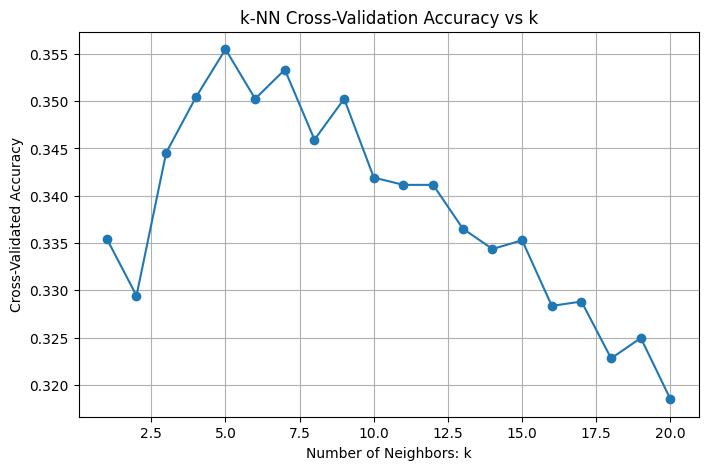

Best k from cross-validation: 5


In [137]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Range of k values to try
k_range = range(1, 21)
cv_scores = []

# Evaluate each k using 5-fold cross-validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot accuracy vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_range, cv_scores, marker='o')
plt.title("k-NN Cross-Validation Accuracy vs k")
plt.xlabel("Number of Neighbors: k")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)
plt.show()

# Best k
best_k = k_range[np.argmax(cv_scores)]
print(f"Best k from cross-validation: {best_k}")

In [138]:
# Train final model with best k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

# Predict on test data
y_pred = best_knn.predict(X_test)

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (2).

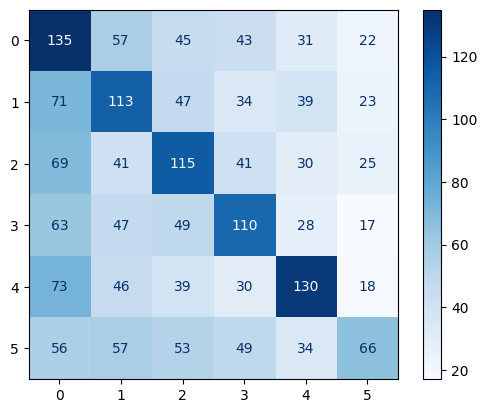

In [139]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (k={best_k})")
plt.grid(False)
plt.show()

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))

In [142]:
train.to_csv("train_process.csv", index=False)
test.to_csv("test_process.csv", index=False)

* ดังนั้น KNN ไม่เวิร์ค ลองไปเล่นตัวใหญ่ๆ ดูบ้าง

In [143]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━

In [145]:
train = train.drop(columns="user_id")

In [146]:
from autogluon.tabular import TabularPredictor
import pandas as pd

# Specify the column to predict (target variable)
label_column = "house"

# Initialize the AutoGluon TabularPredictor
predictor = TabularPredictor(label=label_column, eval_metric="accuracy").fit(train_df, time_limit=600, presets="best", ag_args_fit={'num_gpus': 1})

ImportError: cannot import name 'get_tags' from 'sklearn.utils._tags' (/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py)